# Práctica Whatsapp - Jorge Rivera Rueda

### En esta práctica se hace un análisis del grupo de clase de Telecomunicaciones. Además de las representaciones que vienen por defecto se ha añadido el código necesario para mostrar el top 10 de palabras más utilizadas y para hacer un análisis de la evolución del número de mensajes en el tiempo, del número de mensajes por año y del número de mensajes por mes. También se ha hecho un análisis de los archivos adjuntos por usuario empleando diferentes gráficos y extrayendo conclusiones.

### Inicialización

In [1]:
import io
import sys
import nltk
from nltk.corpus import stopwords

    
def replace_bad_character(line):
    return line.strip().replace(u"\u202a", "").replace(u"\u200e", "").replace(u"\u202c", "").replace(u"\xa0", " ")

try: 
    filepath = raw_input("Please input the chat filepath:")
except NameError:
    filepath = input("Please input chat filepath:")

try:
    with io.open(filepath, "r", encoding="utf-8") as file:
        content = [replace_bad_character(l) for l in file.readlines()]
    
except IOError as e:
    print("File \"" + filepath + "\" not found. Please recheck your file location")
    sys.exit()

common_words = []
cw_filepath = ""

cw_option = "Please select common word file or leave it blank to escape: \n\
    1: Indonesian (id_cw.py)\n\
    2: English (en_cw.py)\n\
    3: Spanish (es_cw.py)\n\
    4: Custom file\n\
    5: Skip common word\n"
try: 
    cw = raw_input(cw_option)
except NameError:
    cw = input(cw_option)
    
if cw == "1":
    cw_filepath = "id_cw"
elif cw == "2":
    cw_filepath = "en_cw"
elif cw == "3":
    cw_filepath = "es_cw"
elif cw == "4":
    """
    Prompt user to input the file path
    """
    try: 
        cw_filepath = raw_input("Please input your common word filepath")
    except NameError:
        cw_filepath = input("Please input your common word filepath")


if len(cw_filepath) > 0:

    try:
        common_words = __import__(cw_filepath, globals(), locals(), [common_words]).common_words
        
    except:
        print("Error getting common word file location")
        sys.exit()
else:
    print("You skipped common word.")

try: 
    verbose = raw_input("You wanna print the verbose mode? y/[N]: ") == "y" or False
except NameError:
    verbose = input("You wanna print the verbose mode? y/[N]: ") == "y" or False


Please input chat filepath: _chat.txt
Please select common word file or leave it blank to escape: 
    1: Indonesian (id_cw.py)
    2: English (en_cw.py)
    3: Spanish (es_cw.py)
    4: Custom file
    5: Skip common word
 3
You wanna print the verbose mode? y/[N]:  N


### Definición de funciones

In [2]:
import re
import errno
import pandas as pd
import emoji
from collections import Counter
from dateutil import parser
import operator
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
"""
Global vars
"""
chat_of_members = {}
member_chat = {"member": [], "chat_count": []}
attachments = {}
attachments_member = {}
refered_web = {"domain": [], "d_count": []}
popular_words = {}
chat_words = ""
emojis = {"emj_char": [], "char_count": []}
heat_map = {
    "day": [], 
    "hour": [], 
    "chat_count": []
}
heat_map2 = {
    "year": [],
    "month": [], 
    "chat_count": []
}
heat_map3 = {
    "date": [],
    "chat_count": []
}
deleted_message = 0
pure_chat = ""
total_chat = 0

"""
Starting line mean a line that started with date time.
Because there are multiline chat. I called it following line.
A starting line must be classified before it's data being extracted.
"""
def is_starting_line(line):
    pattern = r"""
        (\[?)       #Zero or one open square bracket '['
        (((\d{1,2})   #1 to 2 digit date
        (/|-)       #'/' or '-' separator
        (\d{1,2})   #1 to 2 digit month
        (/|-)       #'/' or '-' separator
        (\d{2,4}))   #2 to 4 digit of year
        (,?\s)      #Zero or one comma ',' and ingle space
        ((\d{1,2})  #1 to 2 digit of hour
        (:|\.)      #Colon ':' or dot '.' separator
        (\d{2})     #2 digit of minute
        (\.|:)?     #Zero or one of dot '.' or colon ':'
        (\d{2})?    #Zero or one of 2 digits of second
        (\s[AP]M)?))  #Zero or one of ('space', 'A' or 'P', and 'M'
        (\]?\s-?\s?\s?)#Zero or one close square bracket ']', Zero or one (space and '-'), zero or one space
        (.+)        #One or more character of chat member phone number or contact name
    """
    
    return re.match(re.compile(pattern, re.VERBOSE), line)

"""
"Is Chat" means the body of a line is not an event.
May contains attachment
"""
def is_chat(body):
    pattern = r"""
            ([^:]+)#Chat member
            (:)   #Colon separator
            (.+)  #One or more charachter of message content
    """
    
    return re.match(re.compile(pattern, re.VERBOSE), body)

"""
Classify attachment
Note: in Android, there is no proper description wether it's a image, 
      video, audio, gif, or sticker.
"""
def contains_attachment(body):
    pattern_attachment = [
        ".*<Media omitted>$", #English version of android attachment
        ".*<Media tidak disertakan>$", #Indonesia version of android attachment
        ".*Pesan tidak didukung$", #Some device not recognize sticker attachment
        ".+\.vcf \(file\sterlampir\)$", #Indonesian version of android contact card,
        ".+\.vcf \(file\sattached\)$", #Indonesian version of android contact card,
        ".*image omitted$",
        ".*video omitted$",
        ".*document omitted$",
        ".*Contact card omitted$",
        ".*audio omitted$",
        ".*GIF omitted$",
        ".*sticker omitted$"
    ]
    
    for p in pattern_attachment:
        match = re.match(p, body)
        if match:
            return body
    return None

"""
Event means logs of chat activity e.g member left, member added, removed, etc.
This kind of line can not count as a chat
"""
def is_event(body):
    pattern_event = [
        "Messages to this group are now secured with end-to-end encryption\.$",
        ".+\screated this group$",
        ".+\skeluar$",
        ".+\sleft$",
        ".+\stelah bergabung menggunakan tautan undangan grup ini$",
        ".+\smenambahkan\s.+",
        ".+\sadded\s.+",
        ".+\sremoved\s.+",
        ".*You joined using this group's invite links$",
        ".+'s security code changed\.$",
        ".*telah mengganti nomor teleponnya ke nomor baru. Ketuk untuk mengirim pesan atau menambahkan nomor baru\.$",
        ".*changed their phone number to a new number. Tap to message or add the new number\.$"
    ]
    
    for p in pattern_event:
        match = re.match(p, body)
        if match:
            return match
    return None
"""
Deleted message
"""
def is_deleted(body):
    p = [
        ".*This message was deleted\.$",
        ".*Pesan ini telah dihapus$"
    ]
    
    for p in p:
        match = re.match(p, body)
        if match:
            return body
    return None

"""
EXTRACT TIMESTAMP
"""
def extract_timestamp(time_string):
    return parser.parse(time_string)

"""
Check if chat contais a url
"""
def extract_url(body):
    pattern = "https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+"
    
    return re.findall(pattern, body)

def get_domain(str):
    domain = str.replace("http://", '')
    domain = domain.replace("https://", '')
    domain = domain.split("/")
    return domain[0]

"""
EMOJI
"""
def extract_emojis(string):
    emj = []
    for c in string:
        if c in emoji.UNICODE_EMOJI:
            emj.append(c)

    if len(emj) > 0:
        increment_emoji_count(emj)
    
    return emj

"""
Count top words
"""
def get_words(msg):
    
    #remove non alpha content
    regex = re.sub(r"[^a-z\s]+", "", msg.lower())
    regex = re.sub(r'[^\x00-\x7f]',r'', regex)
    words = regex.split(" ")
    
    for x in words:
        if x:
            rank_word(x)
            
    return words

def rank_word(word):
    
    if not word in common_words:
        popular_words[word] = popular_words.get(word, 0) + 1
        global chat_words
        chat_words += " {0}".format(word)
        
    return word
    
"""
Counting function
"""

"""
Rank the 'Most Active user'
"""        
def increment_chat_count(member):
    member_chat["member"].append(member)
    member_chat["chat_count"].append(1)
    global total_chat
    total_chat += 1
    
    return member

def increment_attachment_count(message):
    
    if "image omitted" in message:
        attachments["image"] = attachments.get("image", 0) +1
        return
        
    if "video omitted" in message:
        attachments["video"] = attachments.get("video", 0) +1
        return
    
    if "audio omitted" in message:
        attachments["audio"] = attachments.get("audio", 0) +1
        return
    
    if "document omitted" in message:
        attachments["document"] = attachments.get("document", 0) +1
        return
    
    if "Contact card omitted" in message or ".vcf" in message:
        attachments["contact"] = attachments.get("contact", 0) +1
        return
    
    if "GIF omitted" in message:
        attachments["gif"] = attachments.get("gif", 0) +1
        return
    
    if "sticker omitted" in message:
        attachments["sticker"] = attachments.get("sticker", 0) +1
        return
    
    ##Unknown attachment
    attachments["unknown"] = attachments.get("unknown", 0) +1
 
"""
Función para calcular el número de cada tipo de attachment por miembro
""" 

def increment_member_attachment_count(member, message):
    
    if member not in attachments_member.keys():
        attachments_member[member] = {
                       'images': 0,
                       'videos': 0,
                       'audios': 0,
                       'documents': 0,
                       'contacts': 0,
                       'gifs': 0,
                       'stickers': 0
                      }
    
    if "image omitted" in message:
        attachments_member[member]['images'] += 1
        return
        
    if "video omitted" in message:
        attachments_member[member]['videos'] += 1
        return
    
    if "audio omitted" in message:
        attachments_member[member]['audios'] += 1
        return
    
    if "document omitted" in message:
        attachments_member[member]['documents'] += 1
        return
    
    if "Contact card omitted" in message or ".vcf" in message:
        attachments_member[member]['contacts'] += 1
        return
    
    if "GIF omitted" in message:
        attachments_member[member]['gifs'] += 1
        return
    
    if "sticker omitted" in message:
        attachments_member[member]['stickers'] += 1
        return
    
    ##Unknown attachment
    attachments_member[member]["unknown"] += 1    

def increment_link_count(urls):
    for url in urls:
        increment_domain_count(get_domain(url))
                    
    return len(urls)
    
def increment_domain_count(domain):
    refered_web["domain"].append(domain)
    refered_web["d_count"].append(1)

def increment_emoji_count(char_list):
    groups = Counter(char_list)
    for c in groups.items():
        emojis["emj_char"].append(c[0])
        emojis["char_count"].append(c[1])
        
def increment_heatmap(dt):
    heat_map["day"].append(dt.strftime("%A"))
    heat_map["hour"].append(dt.strftime("%H"))
    heat_map["chat_count"].append(1)

"""
Función para obtener el número de mensajes por mes y año
"""     
    
def increment_heatmap2(dt):
    heat_map2["year"].append(dt.strftime("%Y"))
    heat_map2["month"].append(dt.strftime("%B"))
    heat_map2["chat_count"].append(1)

"""
Función para obtener el número de mensajes por fecha
"""      
    
def increment_heatmap3(dt):
    heat_map3["date"].append(dt.strftime("%x"))
    heat_map3["chat_count"].append(1)

def increment_deleted():
    global deleted_message
    deleted_message += 1
"""
Self explained
"""
def parse_line(line, verbose):
    prefix = ""
    is_starting = is_starting_line(line)
    
    if is_starting:
        #Check wether the starting line is a chat or an event
        body = is_starting.group(18)
        chat = is_chat(body)
        dt = extract_timestamp(is_starting.group(2).replace(".", ":"))
        increment_heatmap(dt)
        increment_heatmap2(dt)
        increment_heatmap3(dt)
        
        if chat:
            has_attachment = contains_attachment(chat.group(3))
            increment_chat_count(chat.group(1))
            message_body = chat.group(3)
            
            
            if has_attachment:
                prefix = "@@@" 
                increment_attachment_count(has_attachment)
                increment_member_attachment_count(chat.group(1), chat.group(3))
                
                if verbose: print(bcolors.OKBLUE + bcolors.HEADER + prefix + line)
                
            else:
                if is_deleted(message_body):
                    increment_deleted()
                else:
                    prefix = "+++"
                    
                    #URL & Domain
                    urls = extract_url(message_body)
                    if urls:
                        increment_link_count(urls)

                    #Emoji
                    emjs = extract_emojis(message_body)
                    
                    #Word Count & Wordcloud
                    get_words(message_body)
                
                    if verbose: print(bcolors.OKGREEN + bcolors.HEADER + prefix + line)
                
        elif is_event(body):
            prefix = "***"
                
            if verbose: print(bcolors.WARNING + prefix + line)
        
    else:
        prefix = "|||"
        
        #URL & Domain
        urls = extract_url(line)
        if urls:
            increment_link_count(urls)
        
        #Emoji    
        emjs = extract_emojis(line)
        
        #Word Count & Wordcloud
        get_words(line)

        if verbose: print(bcolors.FAIL + prefix + line)

print("Extracting data. Please wait....")

for line in content:
    parse_line(line, verbose)
    
print("Done. You can run next cell.")

Extracting data. Please wait....
Done. You can run next cell.


### DataFrame

In [3]:
"""
DataFrame
"""
chat_per_member = (pd.DataFrame(member_chat)
                     .groupby(["member"])
                     .sum()
                     .sort_values(by = ['chat_count'], ascending=False))
popular_words_df = sorted(popular_words.items(), key=operator.itemgetter(1), reverse=True)
domains = (pd.DataFrame(refered_web)
                     .groupby(["domain"])
                     .sum()
                     .sort_values(by = ['d_count'], ascending=False))
emojis_df = (pd.DataFrame(emojis)
                     .groupby(["emj_char"])
                     .sum()
                     .sort_values(by = ['char_count'], ascending=False))
top_repeated_emoji = (pd.DataFrame(emojis)
                     .sort_values(by = ['char_count'], ascending=False))
top_attachment_member = (pd.DataFrame(attachments_member))
heatmap_df = pd.DataFrame(heat_map)
heatmap2_df = pd.DataFrame(heat_map2)
heatmap3_df = pd.DataFrame(heat_map3)
grouped_heatmap = heatmap_df.groupby(["day", "hour"]).sum().sort_values(by=["chat_count"], ascending=False)
pivoted_heatmap = pd.pivot_table(grouped_heatmap, values='chat_count', index=['day'], columns=['hour'])

print("Done. You can run next cell.")

Done. You can run next cell.


### Top Member Chat

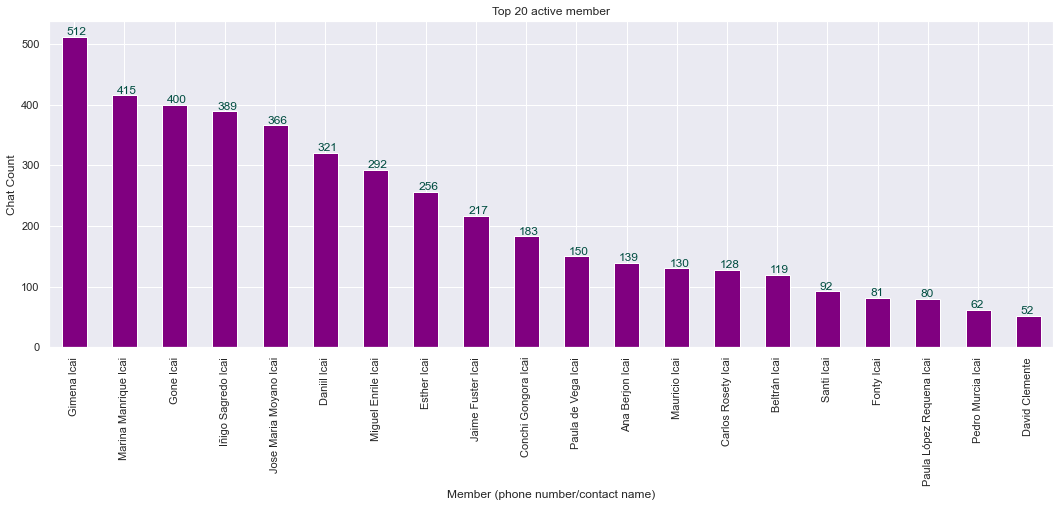

In [4]:
"""
Top Member Chat
"""
top_member = chat_per_member.head(20)
if not top_member.empty:
    sns.set()
    member_plot = top_member.plot(kind='bar', legend=None, title="Top 20 active member", figsize=(18, 6), color="purple")
    member_plot.set_xlabel("Member (phone number/contact name)")
    member_plot.set_ylabel("Chat Count")
    for i, v in enumerate(top_member["chat_count"]):
        member_plot.text(i - .15, v + 3, v, color="#004d40")
else:
    print("This chat has no member")

### Heatmap hora y día con más mensajes

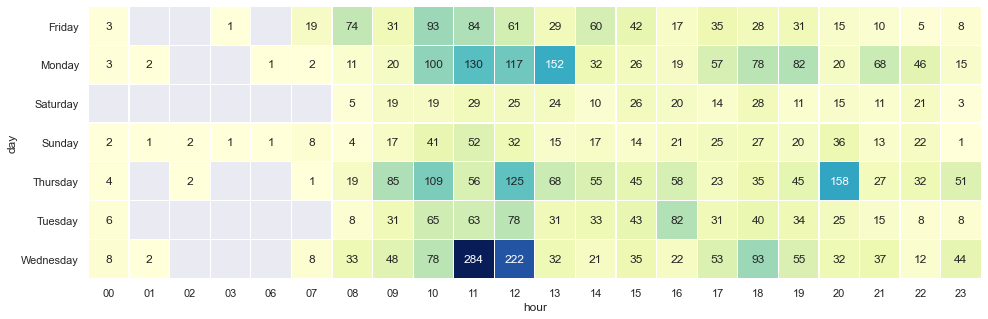

In [5]:
"""
Heatmap
"""
heatmap_df = pd.DataFrame(heat_map)
if not heatmap_df.empty:
    grouped_heatmap = heatmap_df.groupby(["day", "hour"]).sum().sort_values(by=["chat_count"], ascending=False)
    pivoted_heatmap = pd.pivot_table(grouped_heatmap, values='chat_count', index=['day'], columns=['hour'])
    plt.figure(figsize = (16,5))
    sns.heatmap(pivoted_heatmap, 
                annot=True, 
                fmt=".0f", 
                linewidths=.2,
                cmap="YlGnBu",
                cbar=False
               )
else:
    print("This chat does not contain any datetime")

### Distribución tipos de archivos adjuntos

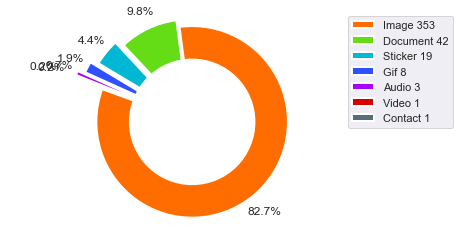

In [6]:
s_attachments = sorted(attachments.items(), key = operator.itemgetter(1), reverse=True)
if s_attachments:
    at_labels = [x[0].title() + " " + str(x[1]) for x in s_attachments]

    at_explode = tuple([0 + i * 0.1 for i in range(len(s_attachments))])
    at_sizes = [x[1] for x in s_attachments]
    at_colors = ["#FF6D00", "#64DD17", "#00B8D4", "#304FFE", "#AA00FF", "#d50000", "#546E7A", "#dddddd"]
    at_pie = plt.pie(at_sizes,  
             autopct='%1.1f%%',
             explode=at_explode,
             pctdistance=1.2,
             colors=at_colors,
             startangle=160,
             radius=1.3,
             wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },
    )

    at_centre_circle = plt.Circle((0,0),0.85,color='white', fc='white',linewidth=1.25)
    at_fig = plt.gcf()
    at_fig.gca().add_artist(at_centre_circle)

    plt.legend(
        loc='upper left',
        labels=at_labels,
        prop={'size': 11},
        bbox_to_anchor=(1, 1)
    )
    at_axis = plt.axis('equal')
else:
    print("This chat contains no attachment.")

### Dominios más mencionados

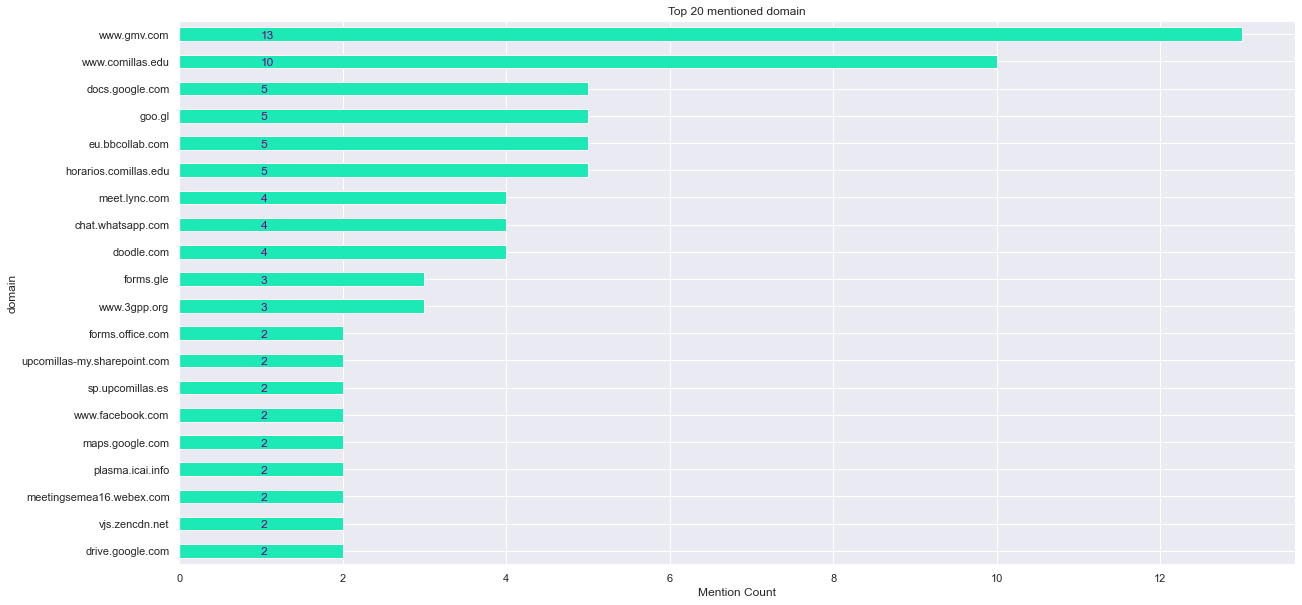

In [7]:
"""
Top Website
"""
top_web = domains.head(20).sort_values("d_count")
if not top_web.empty:
    mpl.rc('font', **{'sans-serif' : 'arial', 'family' : 'sans-serif'})
    web_plot = top_web.plot(kind='barh', legend=None, title="Top 20 mentioned domain", figsize=(20,10), color="#1de9b6")
    web_plot.set_xlabel("Mention Count")
    for i, v in enumerate(top_web["d_count"]):
        web_plot.text(1, i - .15, v, color="purple")
else:
    print("This chat not contains any link")

### Wordcloud

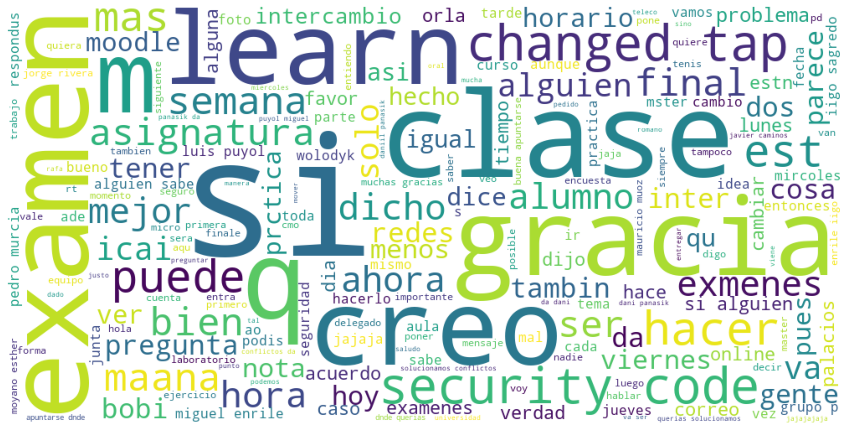

In [8]:
"""
Wordcloud
"""
if chat_words:
    wordcloud = WordCloud(
        width = 1000, 
        height = 500,
        background_color = "white"
    ).generate(chat_words)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
else:
    print("This chat contains no word")

### Top 10 palabras más utilizadas

In [9]:
repeated_words = pd.DataFrame(popular_words_df)
repeated_words.head(10)

,0,1
0,si,610
1,da,292
2,gracias,251
3,examen,213
4,q,196
5,alguien,180
6,clase,179
7,creo,178
8,to,153
9,code,147


### Raw Output

In [10]:
"""
Raw Output
"""
print("\n=======================================\n")
print("#Total Chat: {0}".format(total_chat))
print("#Deleted Message: {0}".format(deleted_message))
print("#Total Attachment: {0}".format(sum([x[1] for x in s_attachments])))
for a in s_attachments:
    print("  - : {0}".format(a))
    


print("\n#Top 20 Member")
print("-----------------")
print(top_member)


print("\n#Top 20 Words")
print("-----------------")
for k, v in enumerate(popular_words_df):
    if k < 20:
        print(v)
    else:
        break
        
print("\n#Top 20 Emoji")
print("-----------------")
print(emojis_df.head(20))

print("\n#Top 20 Mentioned Website")
print("-----------------")
print(top_web.sort_values("d_count", ascending=False))



#Total Chat: 4933
#Deleted Message: 52
#Total Attachment: 427
  - : ('image', 353)
  - : ('document', 42)
  - : ('sticker', 19)
  - : ('gif', 8)
  - : ('audio', 3)
  - : ('video', 1)
  - : ('contact', 1)

#Top 20 Member
-----------------
                          chat_count
member                              
Gimena Icai                      512
Marina Manrique Icai             415
Gone Icai                        400
Iñigo Sagredo Icai               389
Jose Maria Moyano Icai           366
Daniil Icai                      321
Miguel Enrile Icai               292
Esther Icai                      256
Jaime Fuster Icai                217
Conchi Gongora Icai              183
Paula de Vega Icai               150
Ana Berjon Icai                  139
Mauricio Icai                    130
Carlos Rosety Icai               128
Beltrán Icai                     119
Santi Icai                        92
Fonty Icai                        81
Paula López Requena Icai          80
Pedro Murcia Icai   

### Evolución del número de mensajes

In [11]:
heatmap_date_df = pd.DataFrame(heat_map3)

In [12]:
grouped_heatmap_date = heatmap_date_df.groupby("date").sum()

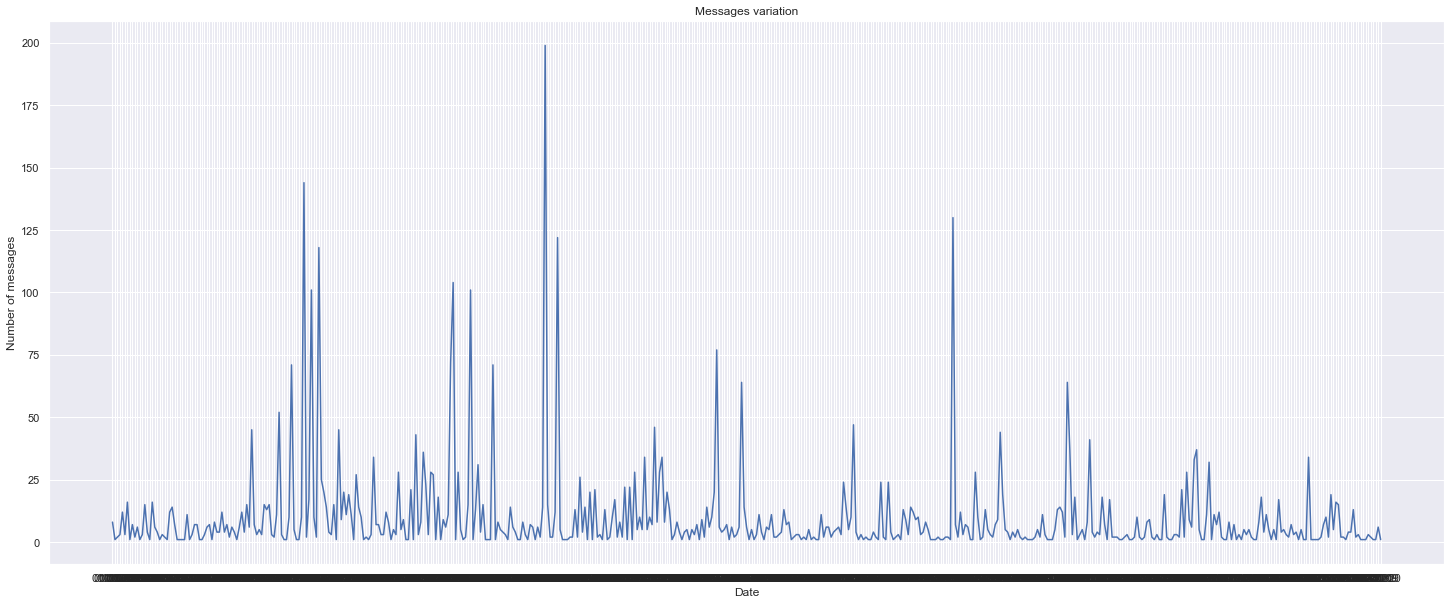

In [13]:
plt.figure(figsize=(25,10))
plt.plot(grouped_heatmap_date.chat_count)
plt.ylabel('Number of messages')
plt.xlabel('Date')
plt.title('Messages variation')
plt.show()

### Análisis y representación del número de mensajes por año

In [14]:
heatmap_year_df = pd.DataFrame(heat_map2)
grouped_heatmap_year = heatmap_year_df.groupby(["year"]).sum()
grouped_heatmap_year

,chat_count
year,
2015,3
2018,1216
2019,1087
2020,2647
2021,44


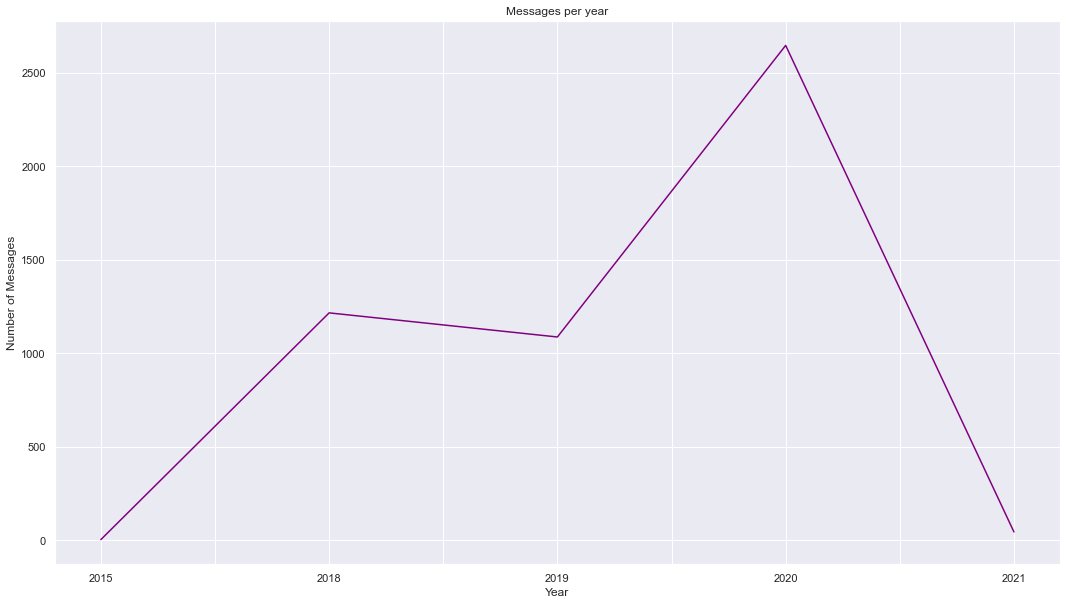

In [15]:
top_years = grouped_heatmap_year["chat_count"]
if not top_years.empty:
    sns.set()
    top_years_plot_line = top_years.plot(kind='line', legend=None, title="Messages per year", figsize=(18, 10), color="purple")
    top_years_plot_line.set_xlabel("Year")
    top_years_plot_line.set_ylabel("Number of Messages")
else:
    print("This chat has no member")

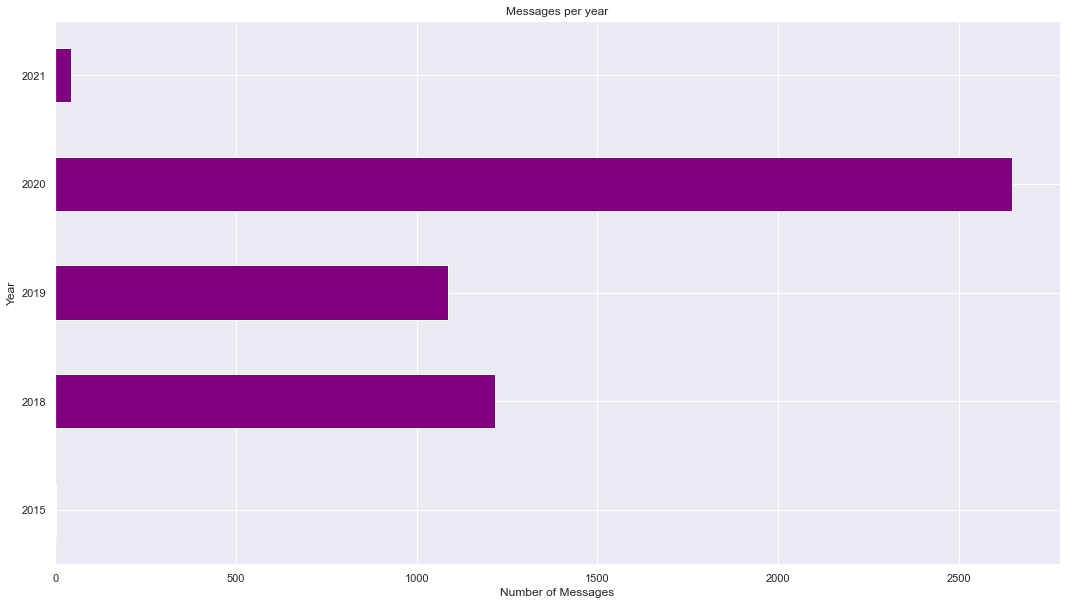

In [16]:
if not top_years.empty:
    sns.set()
    top_years_plot_line = top_years.plot(kind='barh', legend=None, title="Messages per year", figsize=(18, 10), color="purple")
    top_years_plot_line.set_xlabel("Number of Messages")
    top_years_plot_line.set_ylabel("Year")
else:
    print("This chat has no member")

#### Se puede observar como hasta 2018 no aparecen mensajes, a pesar de que el grupo se creó en 2015, esto es porque en 2018 me cambié de móvil y no tengo las conversaciones anteriores a esa fecha. También es interesante destacar que en 2020 fue el año que más mensajes hubo debido a que con el confinamiento todo lo hablábamos por el grupo en vez de en persona, por eso creció tanto el número de mensajes enviados.

### Análisis y representación del número de mensajes por mes

In [17]:
heatmap_month_df = pd.DataFrame(heat_map2)
grouped_heatmap_month = heatmap_month_df.groupby(["month"]).sum()
grouped_heatmap_month

,chat_count
month,
April,700
August,134
December,170
February,964
January,254
July,193
June,223
March,702
May,559


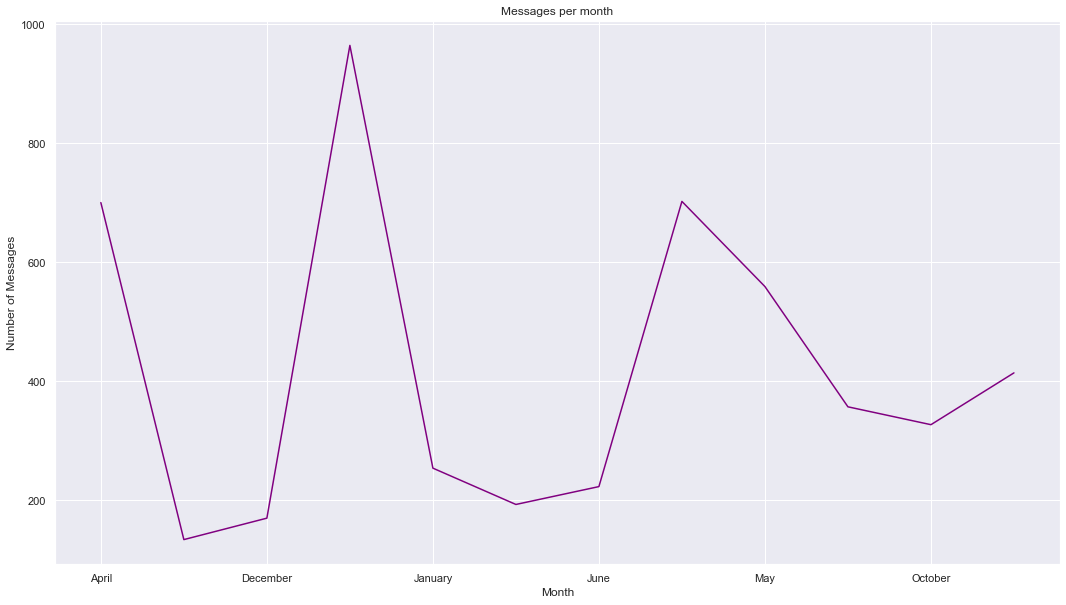

In [18]:
top_months = grouped_heatmap_month["chat_count"]
if not top_months.empty:
    sns.set()
    top_months_plot_line = top_months.plot(kind='line', legend=None, title="Messages per month", figsize=(18, 10), color="purple")
    top_months_plot_line.set_xlabel("Month")
    top_months_plot_line.set_ylabel("Number of Messages")
else:
    print("This chat has no member")

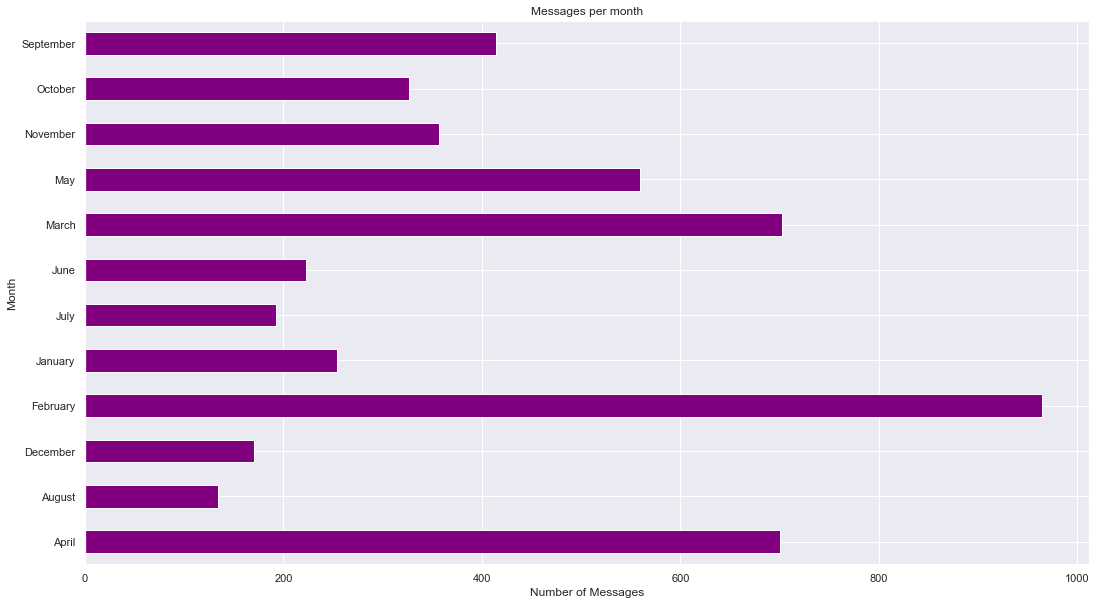

In [19]:
if not top_months.empty:
    sns.set()
    top_months_plot_bar = top_months.plot(kind='barh', legend=None, title="Messages per month", figsize=(18, 10), color="purple")
    top_months_plot_bar.set_xlabel("Number of Messages")
    top_months_plot_bar.set_ylabel("Month")
else:
    print("This chat has no member")

#### En el análisis por meses claramente se ve que los meses de vacaciones, junio, julio, agosto, diciembre y enero en parte, son los meses en los que menos se utiliza el grupo.

### Análisis archivos adjuntos por usuario

In [20]:
attachment_member_df = top_attachment_member.transpose()
attachment_member_df["members"] = attachment_member_df.index
attachment_member_df = attachment_member_df.set_index("members")
attachment_member_df["total"] = attachment_member_df.sum(axis=1)

In [21]:
attachment_member_df

,images,videos,audios,documents,contacts,gifs,stickers,total
members,,,,,,,,
Gimena Icai,39,0,0,3,1,2,1,46
Gone Icai,45,0,1,2,0,0,2,50
Beltrán Icai,15,0,0,1,0,0,2,18
Fonty Icai,2,0,0,0,0,0,1,3
Esther Icai,11,0,1,0,0,0,1,13
Santi Icai,3,0,0,0,0,0,0,3
Ana Huerta Icai,2,0,0,0,0,0,0,2
+33 6 81 62 50 36,6,0,0,0,0,0,0,6
Paula de Vega Icai,7,0,0,0,0,1,3,11


In [22]:
total_attachment_member = attachment_member_df.sort_values("total", ascending=False)
total_attachment_member

,images,videos,audios,documents,contacts,gifs,stickers,total
members,,,,,,,,
Daniil Icai,60,0,0,13,0,0,0,73
Marina Manrique Icai,49,0,0,15,0,0,0,64
Gone Icai,45,0,1,2,0,0,2,50
Gimena Icai,39,0,0,3,1,2,1,46
Iñigo Sagredo Icai,27,0,1,2,0,2,0,32
Jaime Fuster Icai,21,0,0,1,0,2,2,26
Jose Maria Moyano Icai,18,0,0,0,0,0,2,20
Beltrán Icai,15,0,0,1,0,0,2,18
Esther Icai,11,0,1,0,0,0,1,13


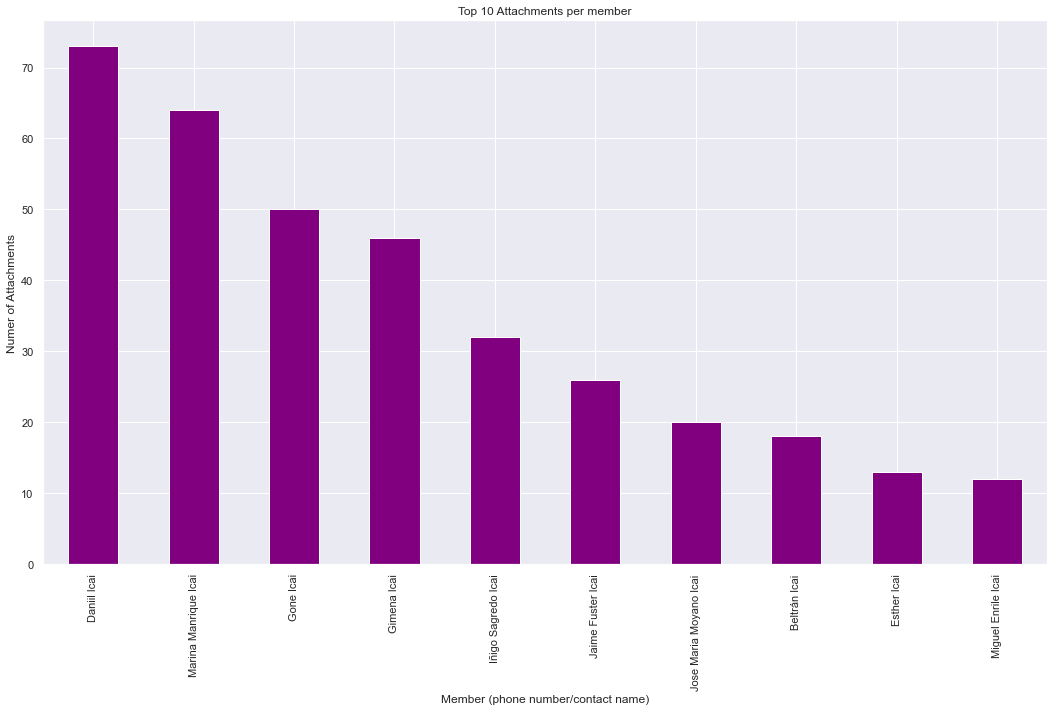

In [23]:
top_attachments_member = total_attachment_member["total"].head(10)
if not top_attachments_member.empty:
    sns.set()
    member_attachments_plot = top_attachments_member.plot(kind='bar', legend=None, title="Top 10 Attachments per member", figsize=(18, 10), color="purple")
    member_attachments_plot.set_xlabel("Member (phone number/contact name)")
    member_attachments_plot.set_ylabel("Numer of Attachments")
else:
    print("This chat has no member")

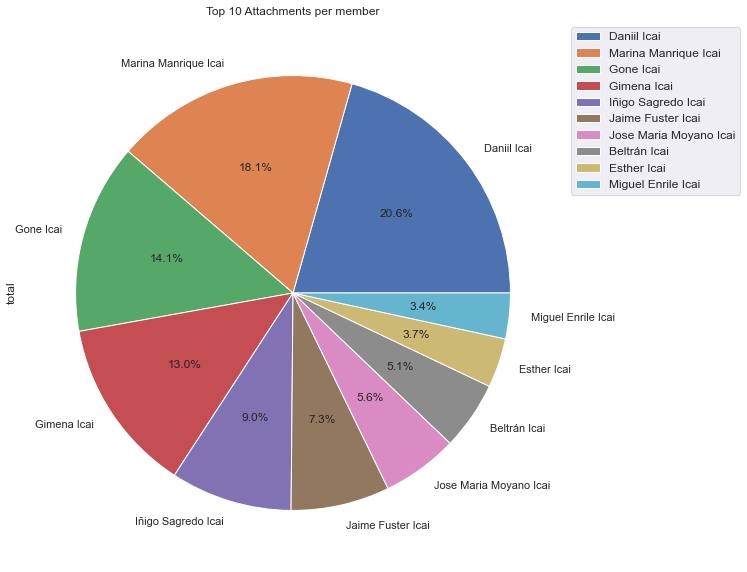

In [24]:
total_attachment_member.head(10).plot.pie(y='total', autopct='%1.1f%%', figsize=(10, 10))
plt.title("Top 10 Attachments per member",bbox={'facecolor':'1', 'pad':5})
plt.legend(
        loc='upper left',
        prop={'size': 12},
        bbox_to_anchor=(1, 1)
    )
plt.show()

#### Este gráfico es muy interesante ya que se observa los participantes que más adjuntos han enviado. Las cuatro personas que más adjuntos han enviado son las personas que han sido o son los delegados de la clase. Tiene sentido que sean los que más imágenes y documentos envían ya que pasan mucha información sobre eventos de la universidad y avisos.

### Análisis imágenes por usuario

In [25]:
images_member = attachment_member_df.sort_values("images", ascending=False)
images_member

,images,videos,audios,documents,contacts,gifs,stickers,total
members,,,,,,,,
Daniil Icai,60,0,0,13,0,0,0,73
Marina Manrique Icai,49,0,0,15,0,0,0,64
Gone Icai,45,0,1,2,0,0,2,50
Gimena Icai,39,0,0,3,1,2,1,46
Iñigo Sagredo Icai,27,0,1,2,0,2,0,32
Jaime Fuster Icai,21,0,0,1,0,2,2,26
Jose Maria Moyano Icai,18,0,0,0,0,0,2,20
Beltrán Icai,15,0,0,1,0,0,2,18
Esther Icai,11,0,1,0,0,0,1,13


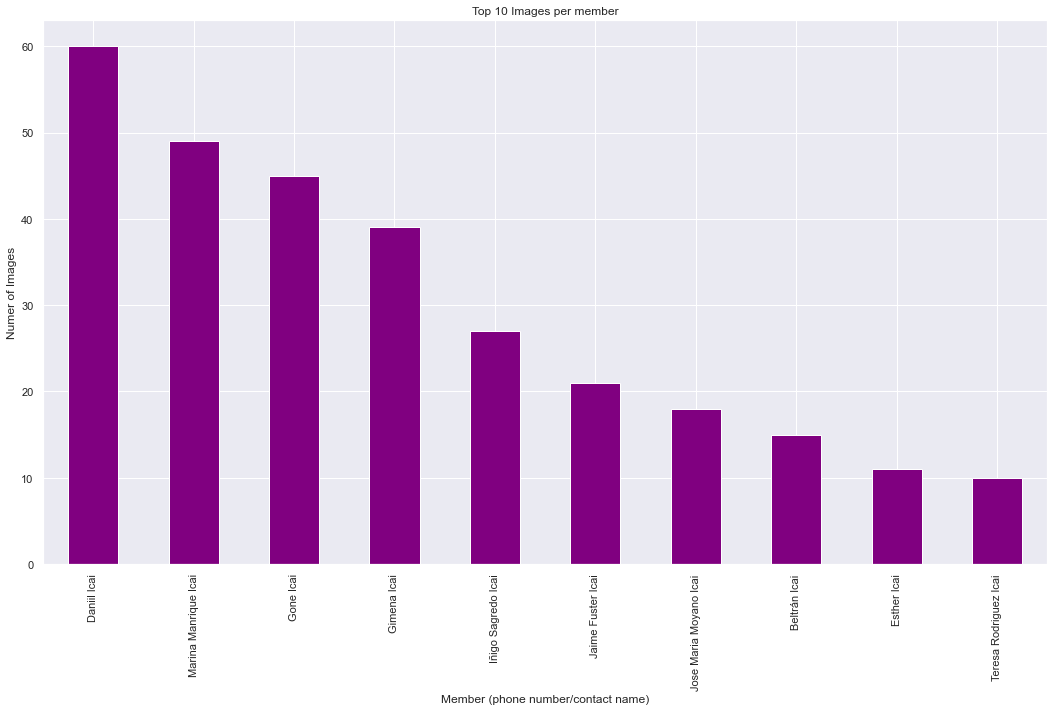

In [26]:
top_images_member = images_member["images"].head(10)
if not top_images_member.empty:
    sns.set()
    member_images_plot = top_images_member.plot(kind='bar', legend=None, title="Top 10 Images per member", figsize=(18, 10), color="purple")
    member_images_plot.set_xlabel("Member (phone number/contact name)")
    member_images_plot.set_ylabel("Numer of Images")
else:
    print("This chat has no member")

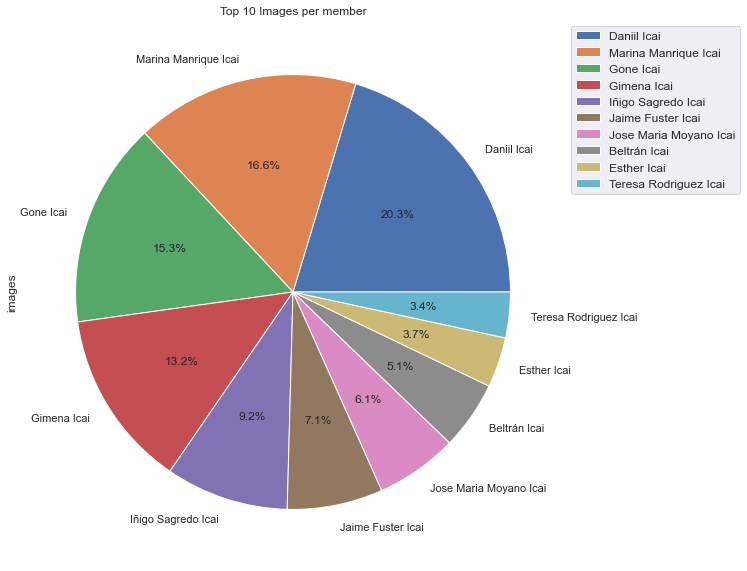

In [27]:
images_member.head(10).plot.pie(y='images', autopct='%1.1f%%', figsize=(10, 10))
plt.title("Top 10 Images per member",bbox={'facecolor':'1', 'pad':5})
plt.legend(
        loc='upper left',
        prop={'size': 12},
        bbox_to_anchor=(1, 1)
    )
plt.show()

### Análisis documentos por usuario

In [28]:
documents_member = attachment_member_df.sort_values("documents", ascending=False)
documents_member

,images,videos,audios,documents,contacts,gifs,stickers,total
members,,,,,,,,
Marina Manrique Icai,49,0,0,15,0,0,0,64
Daniil Icai,60,0,0,13,0,0,0,73
Gimena Icai,39,0,0,3,1,2,1,46
Iñigo Sagredo Icai,27,0,1,2,0,2,0,32
Gone Icai,45,0,1,2,0,0,2,50
Miguel Enrile Icai,9,1,0,2,0,0,0,12
Beltrán Icai,15,0,0,1,0,0,2,18
Luis Puyol,0,0,0,1,0,0,0,1
Jaime Fuster Icai,21,0,0,1,0,2,2,26


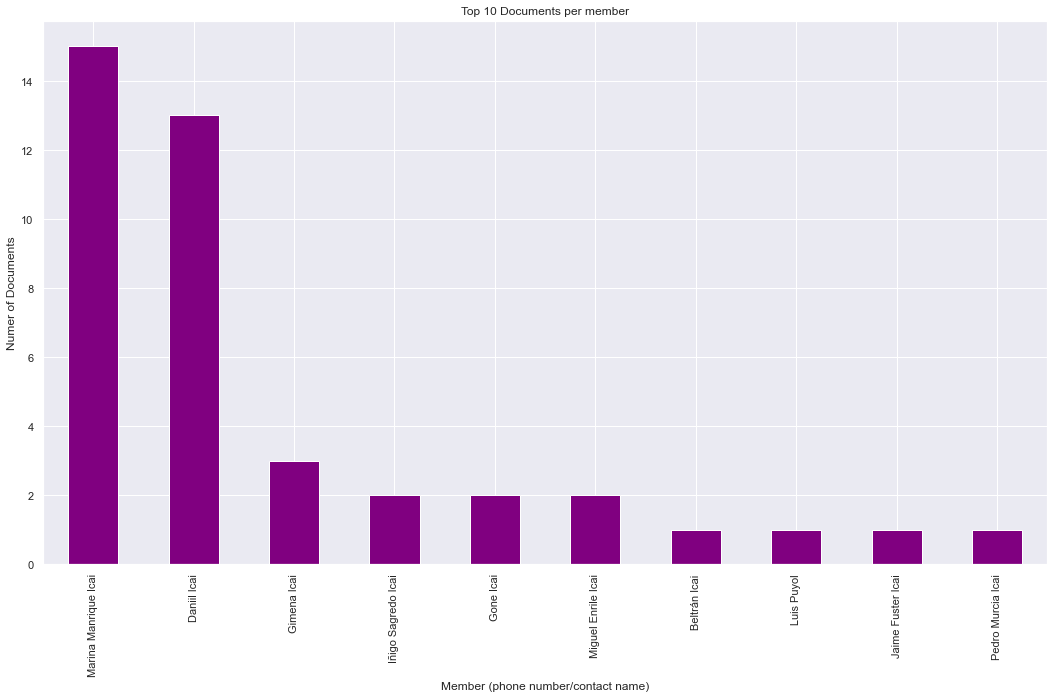

In [29]:
top_documents_member = documents_member["documents"].head(10)
if not top_documents_member.empty:
    sns.set()
    member_documents_plot = top_documents_member.plot(kind='bar', legend=None, title="Top 10 Documents per member", figsize=(18, 10), color="purple")
    member_documents_plot.set_xlabel("Member (phone number/contact name)")
    member_documents_plot.set_ylabel("Numer of Documents")
else:
    print("This chat has no member")

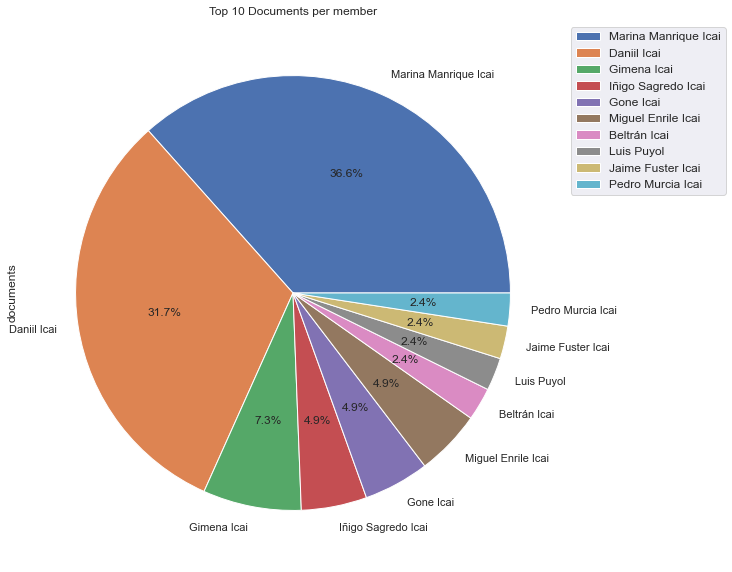

In [30]:
documents_member.head(10).plot.pie(y='documents', autopct='%1.1f%%', figsize=(10, 10))
plt.title("Top 10 Documents per member",bbox={'facecolor':'1', 'pad':5})
plt.legend(
        loc='upper left',
        prop={'size': 12},
        bbox_to_anchor=(1, 1)
    )
plt.show()

### Análisis stickers por usuario

In [31]:
stickers_member = attachment_member_df.sort_values("stickers", ascending=False)
stickers_member

,images,videos,audios,documents,contacts,gifs,stickers,total
members,,,,,,,,
Fran Aranda Icai,1,0,0,0,0,1,3,5
Paula de Vega Icai,7,0,0,0,0,1,3,11
Gone Icai,45,0,1,2,0,0,2,50
Jose Maria Moyano Icai,18,0,0,0,0,0,2,20
Jaime Fuster Icai,21,0,0,1,0,2,2,26
Beltrán Icai,15,0,0,1,0,0,2,18
Javier Caminos Icai,8,0,0,0,0,0,1,9
Esther Icai,11,0,1,0,0,0,1,13
Fonty Icai,2,0,0,0,0,0,1,3


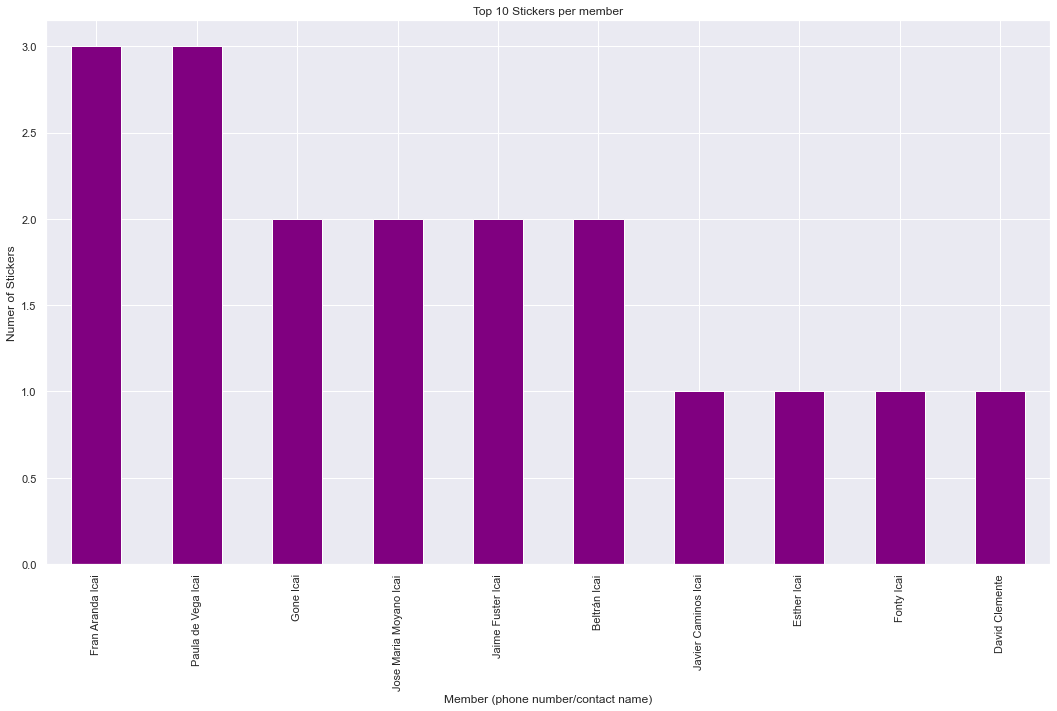

In [32]:
top_sticker_member = stickers_member["stickers"].head(10)
if not top_sticker_member.empty:
    sns.set()
    member_sticker_plot = top_sticker_member.plot(kind='bar', legend=None, title="Top 10 Stickers per member", figsize=(18, 10), color="purple")
    member_sticker_plot.set_xlabel("Member (phone number/contact name)")
    member_sticker_plot.set_ylabel("Numer of Stickers")
else:
    print("This chat has no member")

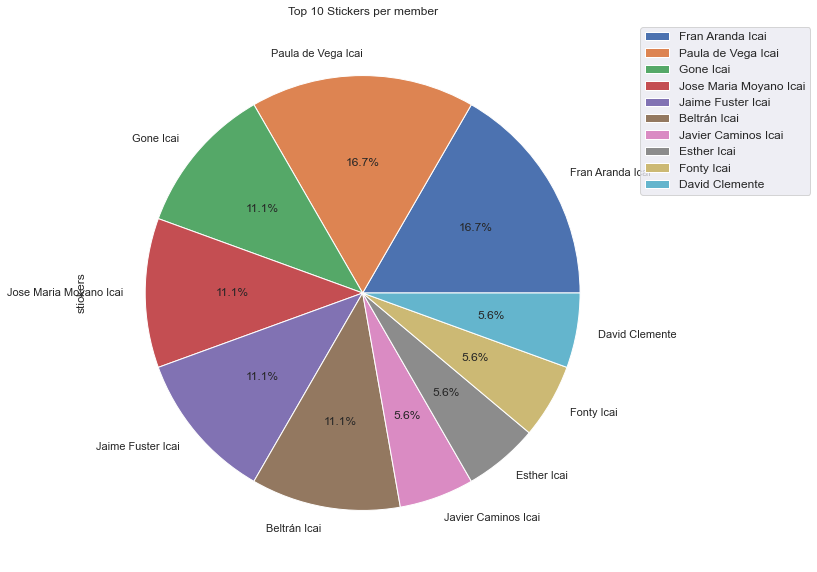

In [33]:
stickers_member.head(10).plot.pie(y='stickers', autopct='%1.1f%%', figsize=(10, 10))
plt.title("Top 10 Stickers per member",bbox={'facecolor':'1', 'pad':5})
plt.legend(
        loc='upper left',
        prop={'size': 12},
        bbox_to_anchor=(1, 1)
    )
plt.show()

#### Las personas que más stickers han enviado ya no coinciden con las personas que han sido delegados. 

### Análisis audios por usuario

In [34]:
audios_member = attachment_member_df.sort_values("audios", ascending=False)
audios_member

,images,videos,audios,documents,contacts,gifs,stickers,total
members,,,,,,,,
Iñigo Sagredo Icai,27,0,1,2,0,2,0,32
Esther Icai,11,0,1,0,0,0,1,13
Gone Icai,45,0,1,2,0,0,2,50
Gimena Icai,39,0,0,3,1,2,1,46
Ana Berjon Icai,1,0,0,0,0,0,0,1
Javier Caminos Icai,8,0,0,0,0,0,1,9
Marina Manrique Icai,49,0,0,15,0,0,0,64
Luis Puyol,0,0,0,1,0,0,0,1
Pedro Murcia Icai,7,0,0,1,0,0,0,8


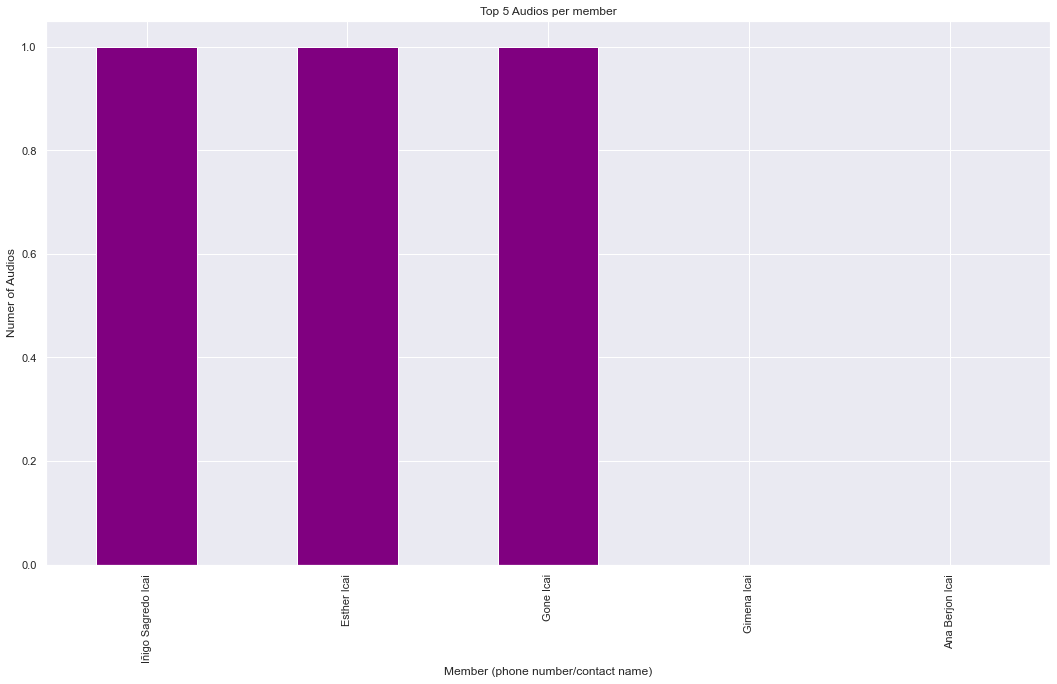

In [35]:
top_audios_member = audios_member["audios"].head(5)
if not top_audios_member.empty:
    sns.set()
    member_audios_plot = top_audios_member.plot(kind='bar', legend=None, title="Top 5 Audios per member", figsize=(18, 10), color="purple")
    member_audios_plot.set_xlabel("Member (phone number/contact name)")
    member_audios_plot.set_ylabel("Numer of Audios")
else:
    print("This chat has no member")

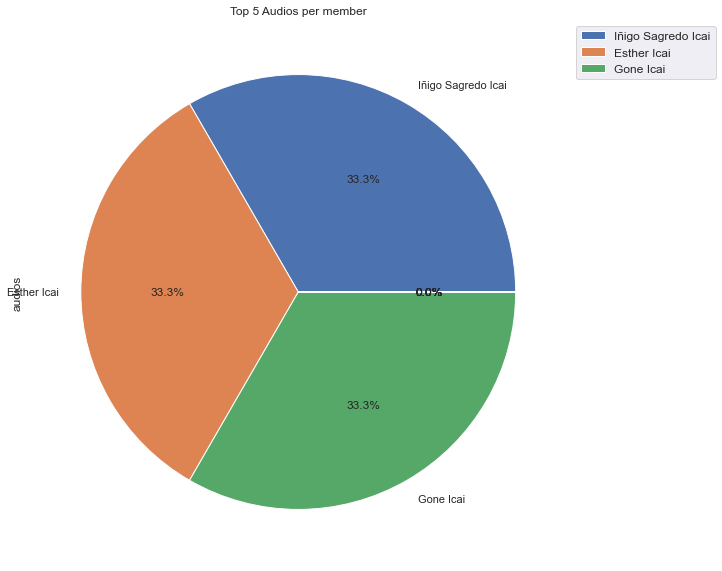

In [36]:
audios_member.head(10).plot.pie(y='audios', autopct='%1.1f%%', figsize=(10, 10))
plt.title("Top 5 Audios per member",bbox={'facecolor':'1', 'pad':5})
plt.legend(
        loc='upper left',
        prop={'size': 12},
        bbox_to_anchor=(1, 1)
    )
plt.show()

#### Solamente tres personas han enviado algún audio por el grupo, esto llama la atención porque cada vez más gente se comunica por audios, pero en el grupo de clase parecen no triunfar.